In [1]:
from gurobipy import *
from random import uniform
import itertools as it
import time
import cProfile as cP
import collections as coll
import math
import numpy as np
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 5
def contig_name(contig):
    return contig[:contig.rfind('_')]

In [2]:
def get_contig_lengths(file):
    contig_len = {}
    for line in file:
        contig, length = line.split()
        length = int(length)
        if contig in contig_len:
            print("Error: double cont: " + contig + " | v1: " + str(contig_len[contig]) + " | v2: " + str(length))
        contig_len[contig] = length
    return contig_len

def read_file(file_name):
    """
    """
    data = []
    with open(file_name) as file:
        for line in file:
            a, b, dist = line.split()
            data.append([a, b, float(dist)])
    return data

def write_file(file_name, data):
    with open(file_name, 'w') as out:
        for a,b,dist in data:
            out.write(a +'\t'+ b +'\t'+str(dist) +'\n')
            
def write_sol(file_name, pos):
    pos = sorted(pos.items(), key = lambda x: x[1])
    with open(file_name, 'w') as out:
        for contig, position in pos:
            out.write(contig +'\t'+ str(position) + '\n')
            
def read_position(datei, ending = True):
    f = open(datei)
    
    position = {}
    contig_repeat = coll.defaultdict(list)
    
    for line in f:
        if ending:
            contig, pos = line.split()
            repeat = contig + '_' + str(len(contig_repeat[contig]))
        else:
            repeat, pos = line.split()
            contig = contig_name(repeat)
        
        position[repeat] = float(pos)
        contig_repeat[contig].append(repeat)
        
    return position, contig_repeat
            
def get_vars(data):
    contigs = set()
    for a, b, _ in data:
        contigs.add(a)
        contigs.add(b)
    return contigs

def find(x, i):
    
    l = [i]
    while i in x and i != x[i]:
        i = x[i]
        l += [i]
    
    for j in l:
        x[j] = i
        
    return i

def union(x,i,j):
    i = find(x,i)
    j = find(x,j)
    x[i] = j
        
def to_sets(struct):
    sets = coll.defaultdict(set)
    for element in struct:
        root = find(struct, element)
        sets[root].add(element)
    return sorted(sets.values(), key = lambda x: len(x), reverse = True)

def connected(data):
    struct = {}
    for a, b, _ in data:
        union(struct, a, b)
    sets = to_sets(struct)
    
    if len(sets) == 1:
        print('Die Daten sind zusammenhängend')
    else:
        print('Es gibt unzusammenhängende Regionen in den Daten')
        value = round(100 * len(sets[0]) / sum(len(x) for x in sets), 2)
        print(str(value) + '% der Contigs sind in der größten Komponente.')
       # print(sum(len(x) for x in sets[1:]))
       #print(sum(len(x) for x in sets[:]))
        
    return [constraint for constraint in data if constraint[0] in sets[0]]
#connected('my_apd200.lst')

In [3]:
def solve_LP(contigs, data):
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(contigs)
    
    model.update()
        
    # Bedingungen
    fehler = []
    bedingung = []
    for a, b, dist in data:
        eps = model.addVar()
        model.addConstr( contig[b] - contig[a] - dist <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in contig}

#position = solve_LP_X(position_, dataX, X)
def solve_LP_X(position, data, X):
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(X)
    
    contig.update(position)
    model.update()
        
    # Bedingungen
    fehler = []
    bedingung = []
    for a, b, dist in data:
        eps = model.addVar()
        model.addConstr( contig[b] - contig[a] - dist <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in X}


In [4]:
def umsortieren(data, repeats, position):
    counter = 0
    for i, bedingung in enumerate(data):
        a, b, dist = bedingung
        
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        if contig_a not in repeats or contig_b not in repeats:
            print('not',a, b, dist)
            continue
        
        new_a, new_b = min( 
            it.product(repeats[contig_a], repeats[contig_b]), 
            key = lambda contig: abs(position[contig[1]] - position[contig[0]] - dist)
        )
            
        bedingung[0] = new_a
        bedingung[1] = new_b
        if new_a != a or new_b != b:
            counter += 1
         #   print('\t'.join([a,b,str(dist),str(position[b] - position[a])]))
          #  print('\t'.join([new_a, new_b,str(dist), str(position[new_b] - position[new_a])]))
          #  print()
    print('Anzahl der Änderungen:',counter)
    print()

def get_X_pos(data, position, X):
    constr_pos = coll.defaultdict(list)
    for a, b, dist in data:
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        if b in X:
            constr_pos[contig_b].append((position[a] + dist, a, 1))
        if a in X:
            constr_pos[contig_a].append((position[b] - dist, b, 0))
    return dict(constr_pos)

def extrahiere_daten(gruppe):
    gruppe, counter, dist  = gruppe
    
    Repeat = coll.namedtuple('Repeat', ['pos', 'güte'])

    anzahl = len(gruppe)
    güte = (anzahl-1)**2 * (max(counter.values()) - 1) * (len(dist) - 1) / (200+np.std(gruppe))
    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte
    )
   
    
def gruppierung(positionen, anzahl, min_abstand):
    
    sorted_pos = sorted(positionen) 
    # gruppiere sich stützende Daten
    previous = sorted_pos[0][0]
    current_group = [[],coll.Counter(),set()]
    groups = []
    gruppen_abstand = []
    for current, contig, direction in sorted_pos:
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],coll.Counter(),set()]
            gruppen_abstand.append([current - previous, groups[-1], current_group])
        current_group[0].append(current)
        current_group[1][contig] += 1
        current_group[2].add(direction)
        previous = current
    groups.append(current_group)
    
    if len(groups) <= anzahl:
        return
    
    
    gruppen_abstand.sort()
    
    repeat_daten = [extrahiere_daten(g) for g in groups]
    repeat_daten.sort(key = lambda x: x.güte, reverse=True)
    # print('daten')
    #for x in repeat_daten:
    #    print(x)
    max_güte = repeat_daten[anzahl].güte
    ret = deepcopy([max_güte, repeat_daten[:anzahl+1], groups])
    for abstand, g1, g2 in gruppen_abstand[:-anzahl]:
        g1[0] += g2[0]
        g1[1] += g2[1]
        g1[2] |= g2[2]
        
        groups.remove(g2)
        
        repeat_daten = [extrahiere_daten(g) for g in groups]
        repeat_daten.sort(key = lambda x: x.güte, reverse=True)
        
        #print('merge')
        #for x in repeat_daten:
        #    print(x)
        güte =  repeat_daten[anzahl].güte
        if güte > max_güte:
            max_güte = güte
            ret = deepcopy([güte, repeat_daten[:anzahl+1], groups])
    
   # print(repeat_daten)
    return ret


def get_repeat(constr_pos, contig_repeats, min_repeat_abstand = 500, min_güte = 0):
    max_güte = min_güte
    for contig in constr_pos:
        groups = gruppierung(constr_pos[contig], len(contig_repeats[contig]), min_repeat_abstand)
        if not groups:
            continue
            
        güte, repeats, groups = groups
        
        if güte > max_güte:
            max_güte = güte
            ret = contig, repeats, güte, groups
    if max_güte == min_güte:
        return None, None, 0,[]
    print('güte', max_güte)
    #for r in ret[1]:
    #    print(r)
    for g in ret[3]:
        data = g[0]
        anzd = len(data)
        anzC = len(g[1])
        np.mean(g[0])
        print(int(data[anzd//2]),anzd,anzC,np.std(data))
    print()
    return ret

In [5]:
def get_intName(position):

    pos = sorted([(value, key) for key, value in position.items()])
    
    intName = {k: i for i, (v, k) in enumerate(pos)}
    intName.update({i: k for i, (v, k) in enumerate(pos)})
    
    return intName


def plot_graph(position, data, intName, X, repeat, von = 240, bis = 280, kantenanzahl = 3, fehler = 1000):

    s = coll.defaultdict(set)
    p = coll.defaultdict(set)

    graph = nx.DiGraph() 
    for c in X:
        if contig_name(c) == repeat:
            graph.add_node(intName[c],color = 'green')
        else:
            graph.add_node(intName[c],color = 'red')
    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a].add(b)
            p[b].add(a)
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    
    for el in pp:
        for pr in pp[el]:
            graph.add_edge(intName[pr],intName[el])
           # graph.add_edge(pr,el)
    for el in ss:
        for su in ss[el]:
          #  graph.add_edge(el,su)
            graph.add_edge(intName[el],intName[su])

    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    
    pydot.write_png('t.png')
    display(Image(filename='t.png'))
    

In [ ]:
def init_X(datei, X):
    data = read_file(datei)
    r = coll.Counter()
    for a,b,d in data:
        r[a] += 1
        r[b] += 1
    
    data = [[a,b,d] for a,b,d in data if r[a] > 1 and r[b] > 1]# and a not in X and b not in X]
    data = connected(data)
    
    data_ = [d for d in data if d[0] not in X and d[1] not in X]
    connected(data_)
    dataX = [d for d in data if d[0] in X or d[1] in X]
    
    position = {a for a,_,_ in data} | {b for _,b,_ in data}
    position_ = position - X
    
    contig_repeat = coll.defaultdict(list)
    for contig in position:
        contig_repeat[contig_name(contig)].append(contig)
        
    #Ret = coll.namedtuple('Ret', ['contig','güte'])
    #ret = Ret(contig = [], güte = [])
    
    position_ = solve_LP(position_, data_)
    print('max', max(position_.values()))
    return data, dataX, position_, X, contig_repeat 
def verbessere_loop(data, dataX, position_, X, contig_repeat): 
    while True:
        position = solve_LP_X(position_, dataX, X)
        position.update(position_)
        
        umsortieren(dataX, contig_repeat, position)
        
        constr_pos = get_X_pos(dataX, position, X)
        
        contig, repeats, güte, groups = get_repeat(constr_pos, contig_repeat, min_güte=50)
        if güte == 0:
            print('by')
            break
        print(str(len(contig_repeat[contig])) + '. Repeat von ' + contig)
        print('alte Positionen:')
        for rep in contig_repeat[contig]:
            print('\t', position[rep])
            
        new_contig = contig +'_'+ str(len(contig_repeat[contig]))
        contig_repeat[contig].append(new_contig)
        X.add(new_contig)
        print('neue Positionen:')
        for name, werte in zip(contig_repeat[contig], repeats):
            position[name] = werte.pos
            print('\t', werte.pos)
            
        print('ordne neuem repeat zu: ')
        umsortieren(dataX, contig_repeat, position)
        print()
        print()
    
        plot_graph(position, data, get_intName(position), X, contig)
    return position, data, dataX
datas, dataXs, position_s, Xs, contig_repeats = init_X('my_apd199.lst', {'407APD_0','462APD_0','491APD_0'})
data =  deepcopy(datas)
XX = deepcopy(Xs)
dataX = [d for d in data if d[0] in XX or d[1] in XX]
i = verbessere_loop(data, dataX, deepcopy(position_s), XX, deepcopy(contig_repeats))
Xs,XX

Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
Die Daten sind zusammenhängend
Academic license - for non-commercial use only
Optimize a model with 243204 rows, 123680 columns and 728612 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-06, 8e-06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 502 rows and 252 columns
Presolve time: 1.72s
Presolved: 242702 rows, 123428 columns, 728106 nonzeros


Barrier performed 0 iterations in 3.40 seconds
Optimization interrupted


Stopped in 0 iterations and 3.40 seconds


In [ ]:
p = i[0]
d = i[1]
l = get_contig_lengths(open('APDContigs.len'))
print(p['615APD_0'],p['407APD_0'])
print(p['407APD_0'] + l['407APD'])
print(p['694APD_0'] + l['694APD'])
print(p['491APD_0'] + l['491APD'])

Optimize a model with 244358 rows, 124263 columns and 732078 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-06, 8e-06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 500 rows and 251 columns
Presolve time: 0.99s
Presolved: 243858 rows, 124012 columns, 731574 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1284
 AA' NZ     : 4.310e+06
 Factor NZ  : 6.621e+06 (roughly 200 MBytes of memory)
 Factor Ops : 9.463e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.36938266e+05  3.66943992e+01  0.00e+00 0.00e+00  7.36e+04     4s
   1   7.36897954e+05  2.94983687e+02  0.00e+00 3.46e-07  2.36e+00     4s
   2   1.49594628e+05  5.35401461e+02  0.00e+00 3.19e-07  4.16e-01     5s
   3  

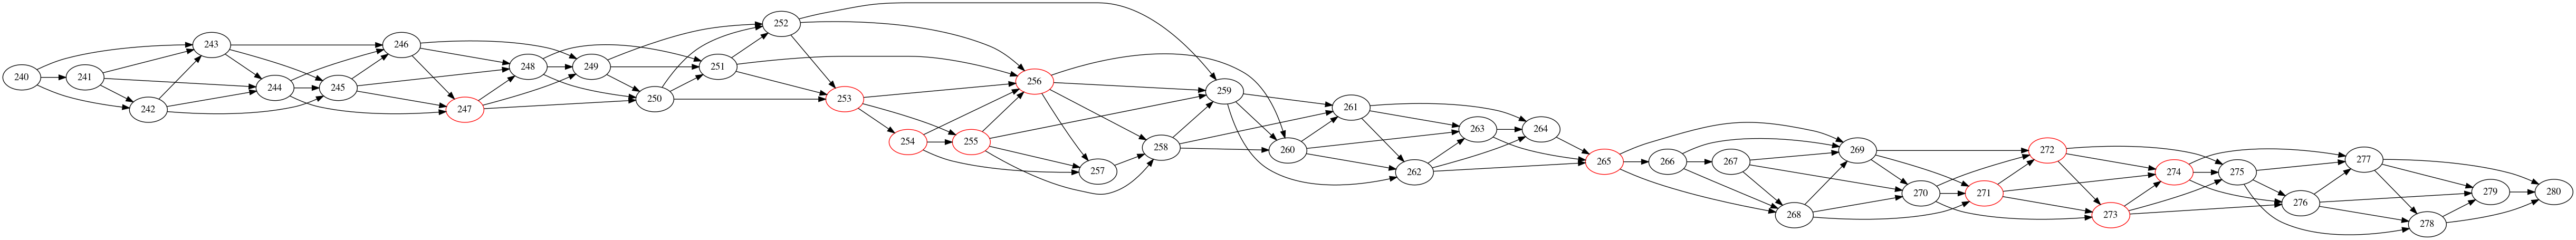

In [57]:
data = deepcopy(i[1])

position = {a for a,_,_ in data} | {b for _,b,_ in data}
position = solve_LP(position, data)
plot_graph(position, data, XX, None)

Anzahl der Änderungen: 0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.3637073189467404
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.26521301793643276
0.0
0.0
0.0
0.0
güte 2.3637073189467404
558872 1 1 0.0
570281 3 1 47.48567035315905
572196 5 1 76.00631552706658
581144 158 94 140.9001532549672
582114 2 2 19.0
590092 5 1 76.00631552706658
592007 3 1 47.48567035315905
621860 1 1 0.0
644130 144 115 277.88914662611285
652605 14 6 228.9871219977585
671800 1 1 0.0

2. Repeat von 58APD
alte Positionen:
	 581144.0
	 644131.0
neue Positionen:
	 581144.0
	 644130.0
	 652605.0
ordne neuem repeat zu: 
Anzahl der Änderungen: 23





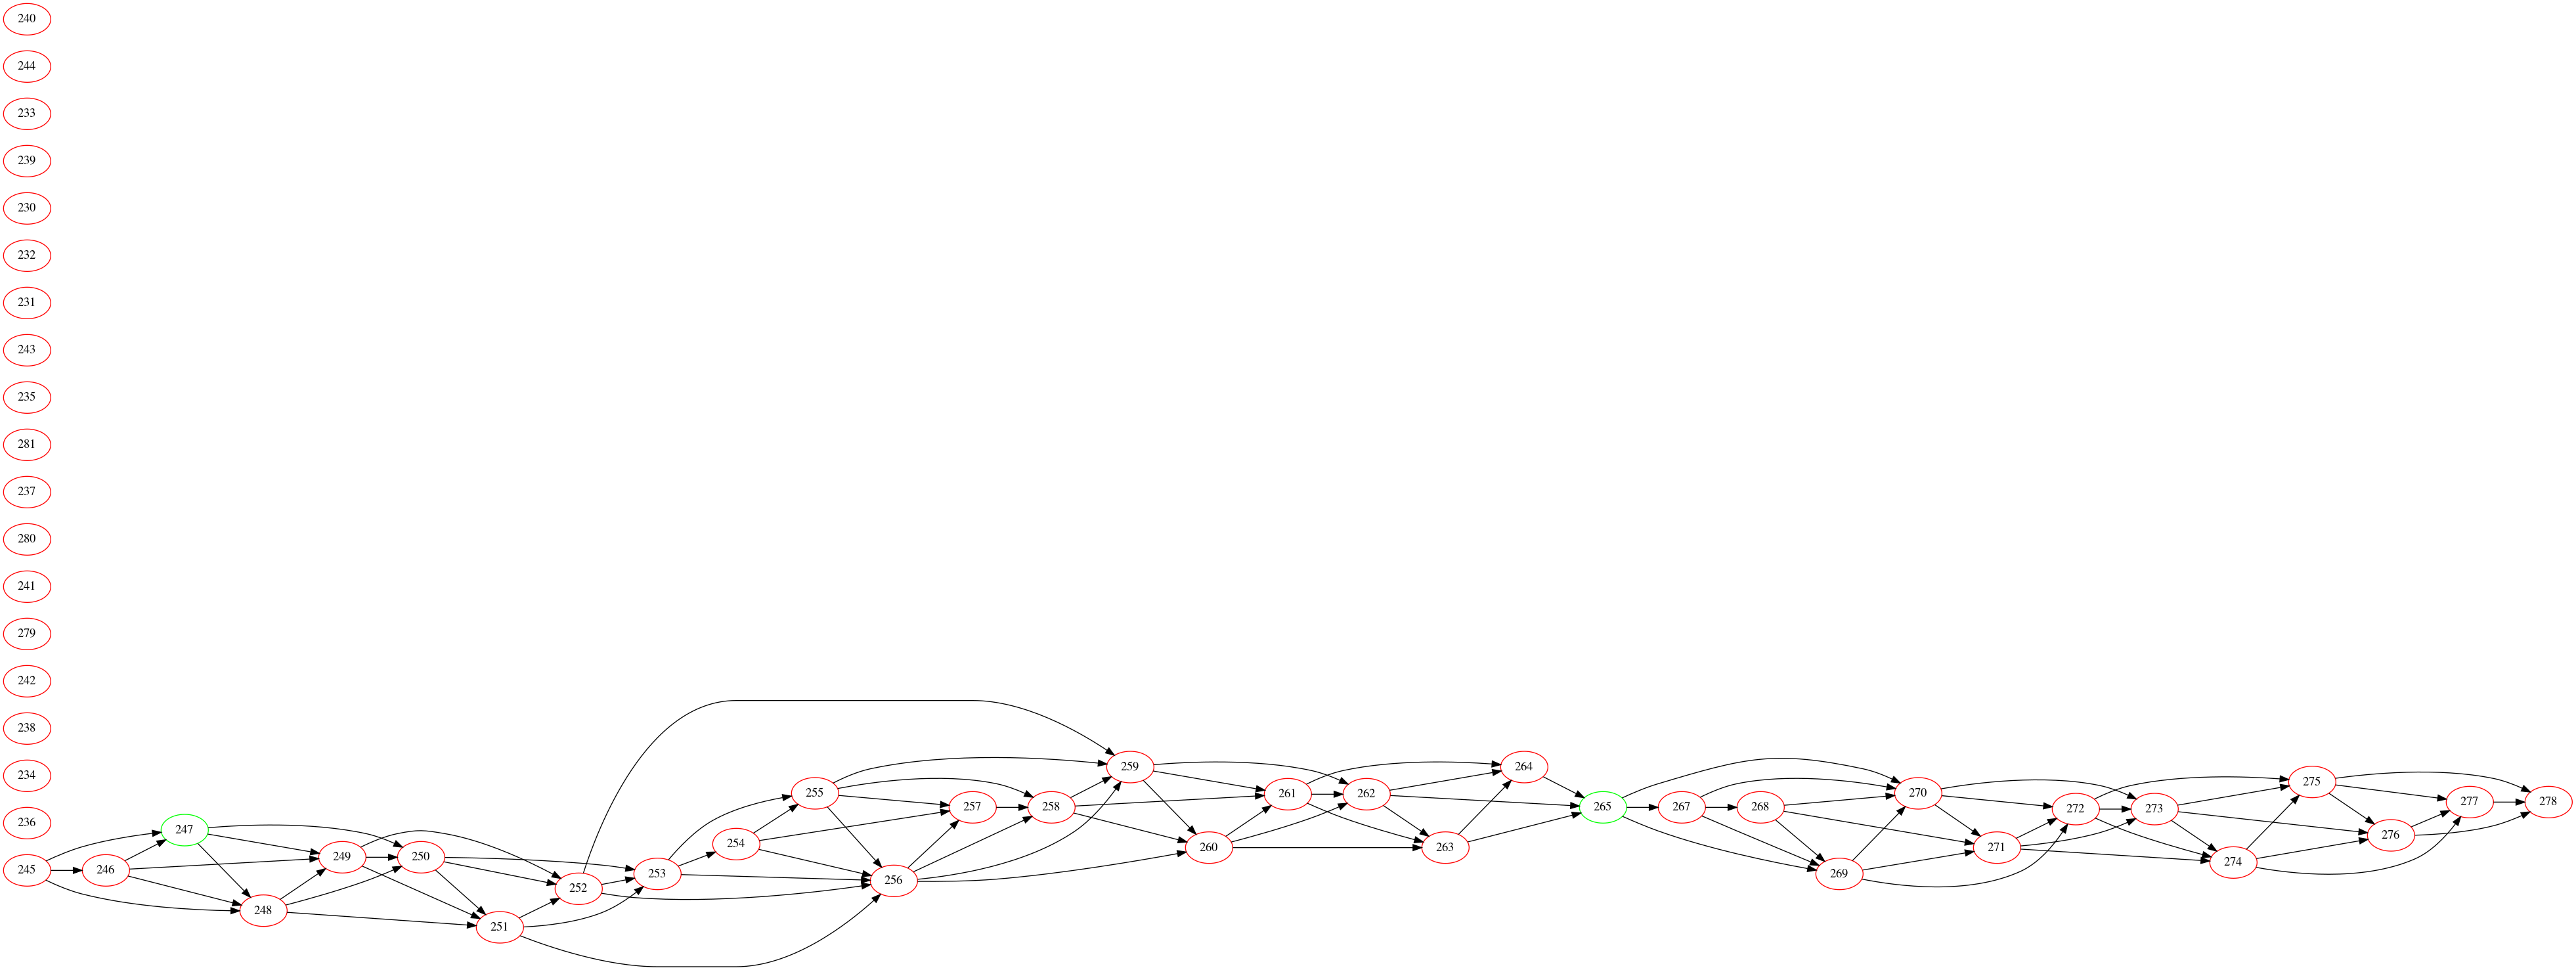

In [58]:
pos = sorted([(value, key) for key, value in position.items()])
intName = {k: i for i, (v, k) in enumerate(pos)}
intName.update({i: k for i, (v, k) in enumerate(pos)})
Y = {c for c in position if 230 <= intName[c] <= 280}

contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)
        
umsortieren(data, contig_repeat, position)

constr_pos = get_X_pos(data, position, Y)

contig, repeats, güte, groups = get_repeat(constr_pos, contig_repeat)

print(str(len(contig_repeat[contig])) + '. Repeat von ' + contig)
print('alte Positionen:')
for rep in contig_repeat[contig]:
    print('\t', position[rep])

new_contig = contig +'_'+ str(len(contig_repeat[contig]))
contig_repeat[contig].append(new_contig)
X.add(new_contig)
print('neue Positionen:')
for name, werte in zip(contig_repeat[contig], repeats):
    position[name] = werte.pos
    print('\t', werte.pos)

print('ordne neuem repeat zu: ')
umsortieren(dataX, contig_repeat, position)
print()
print()
plot_graph(position, data, Y, contig,245,278)

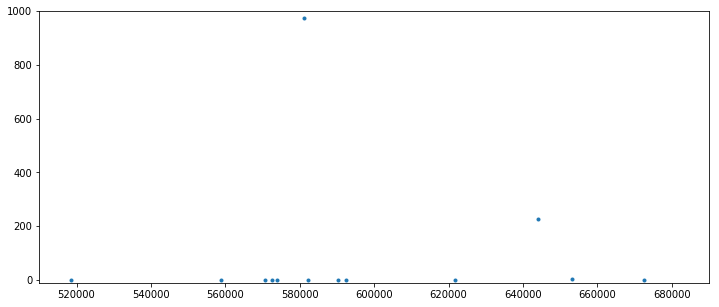

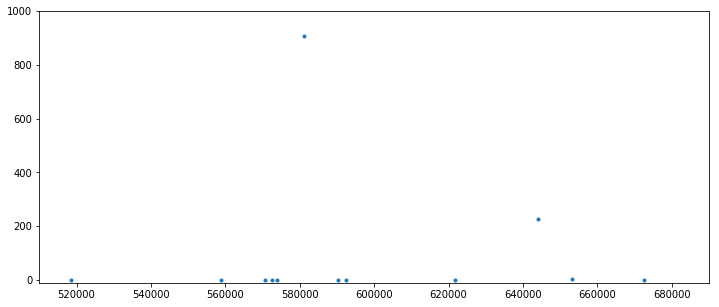

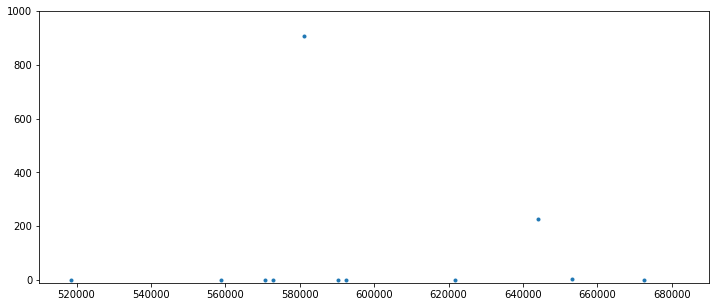

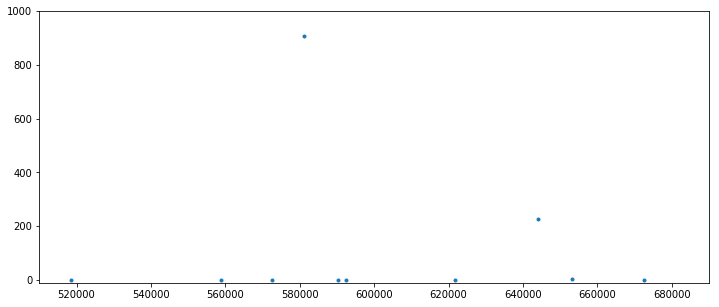

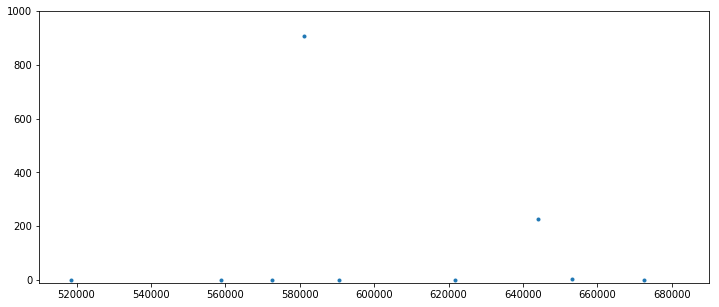

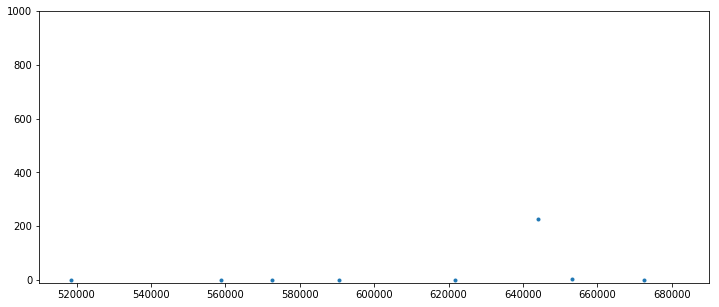

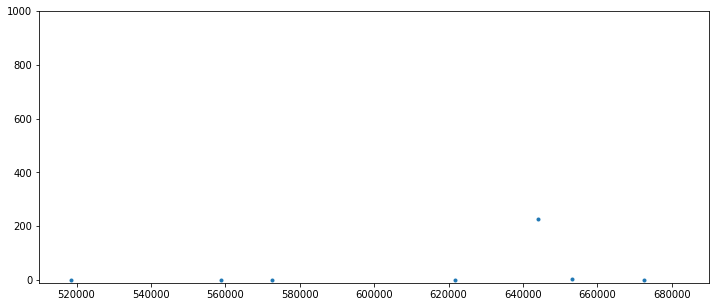

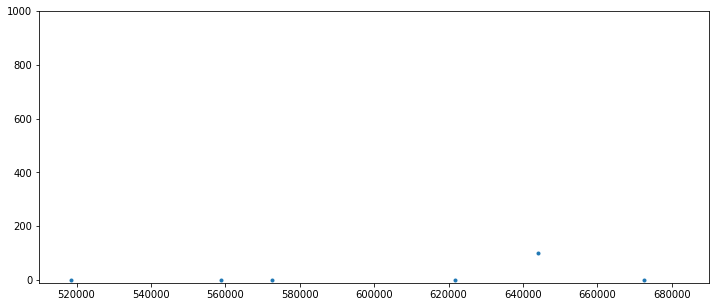

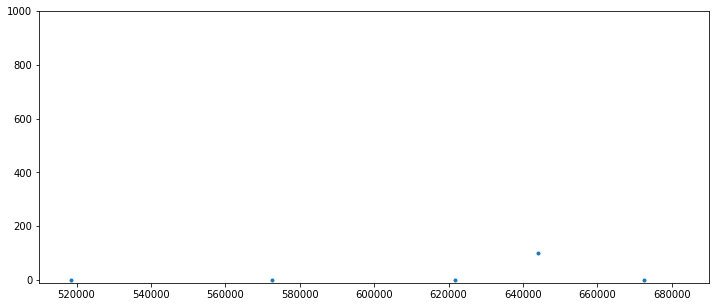

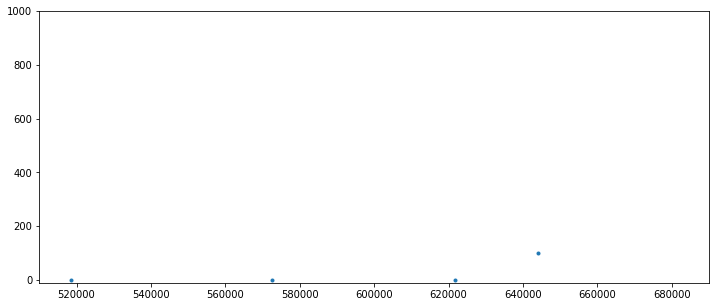

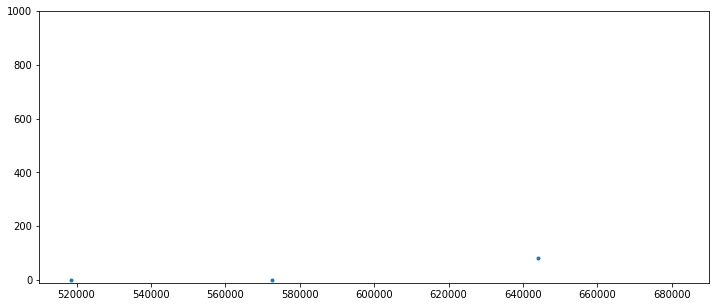

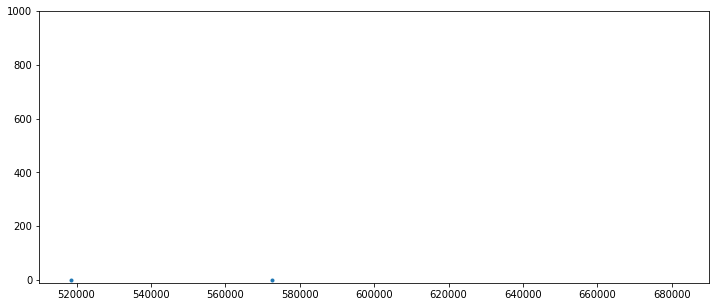

In [97]:
aa = [[[float(cc.split('=')[1][:-1]) for cc in bb.split()] for bb in aa.splitlines() if bb] for aa in t.split('merge')]
for zz in aa:
    zz.sort()
    xx = [xx for xx,_ in zz]
    yy = [yy for _,yy in zz]
    plt.plot(xx,yy,'.')
    plt.ylim([-10,1000])
    plt.xlim([510000,690000])
    plt.show()
    
   # plt.yscale('log')

In [65]:
float(aa),aa.isdigit()

(581153.0393698852, False)

In [70]:
aa = [[[float(cc.split('=')[1][:-1]) for cc in bb.split()] for bb in aa.splitlines() if bb] for aa in t.split('merge')]

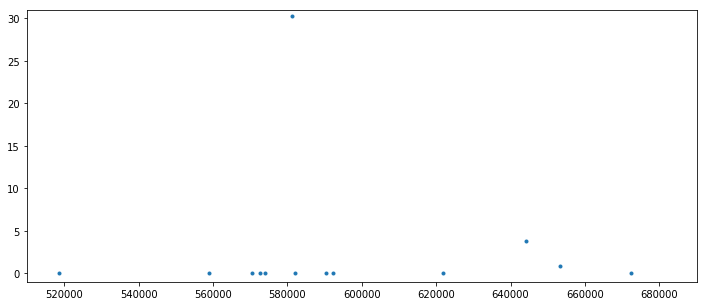

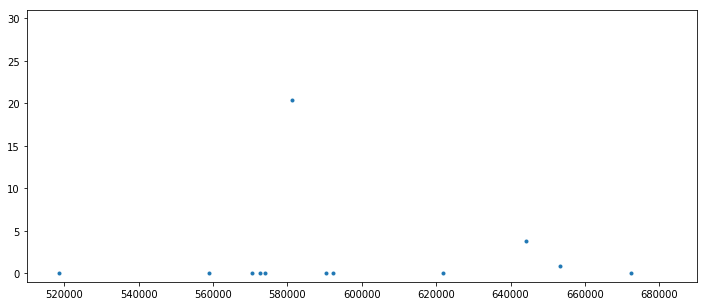

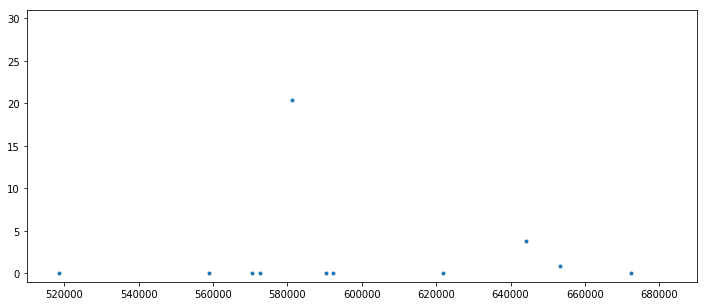

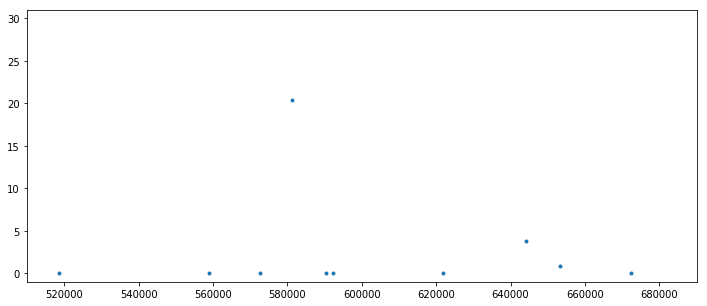

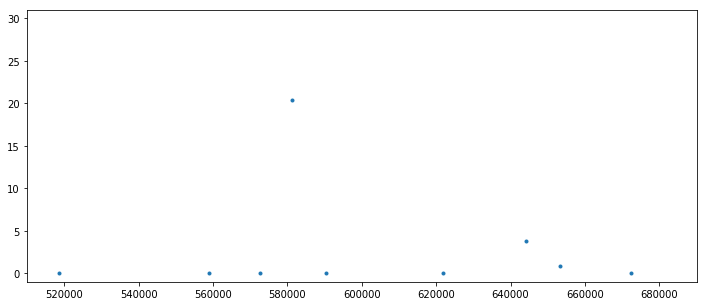

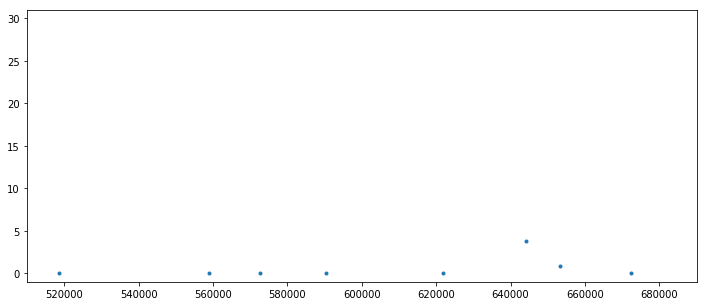

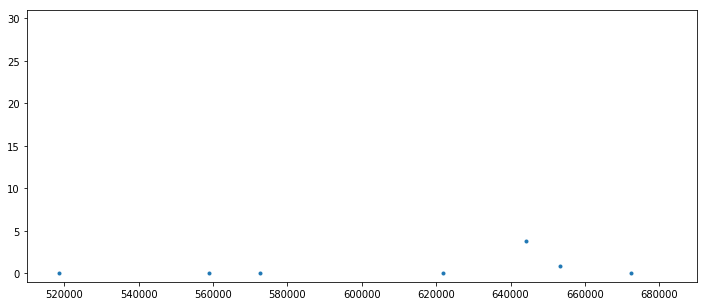

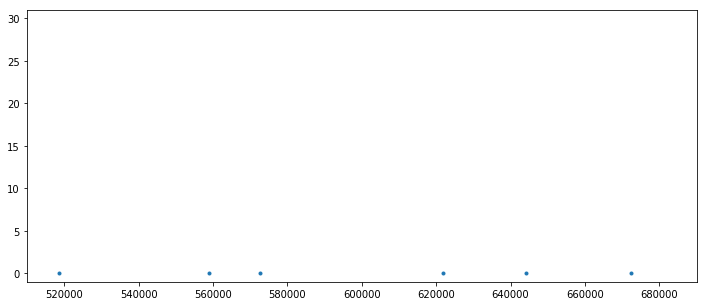

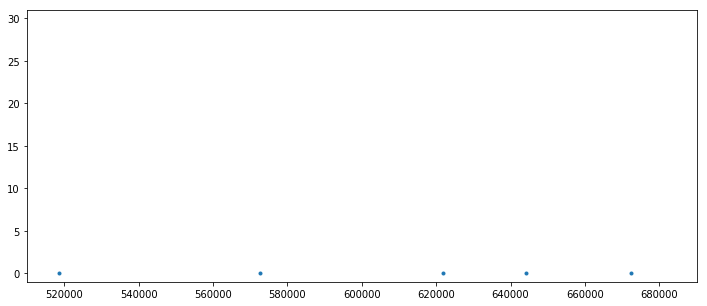

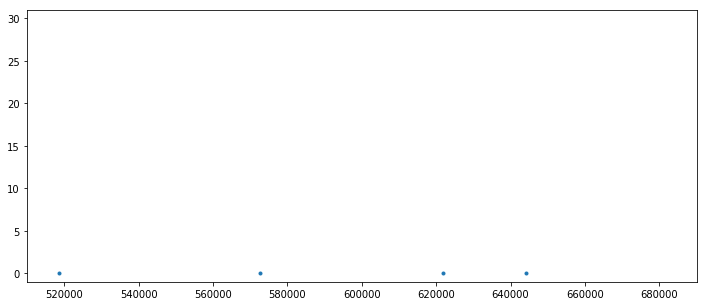

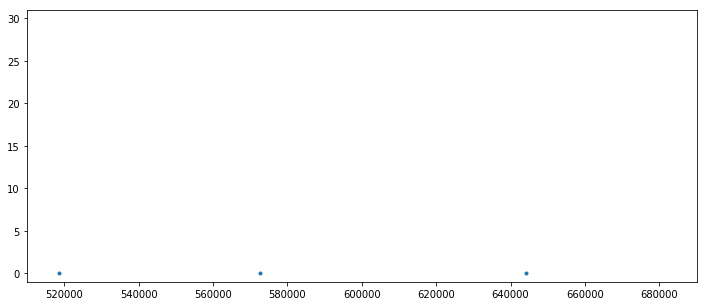

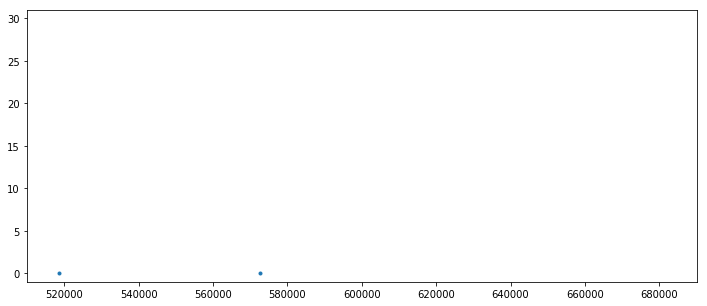

In [83]:
for zz in aa:
    zz.sort()
    xx = [xx for xx,_ in zz]
    yy = [yy for _,yy in zz]
    plt.plot(xx,yy,'.')
    plt.ylim([-1,31])
    plt.xlim([510000,690000])
    plt.show()
    
   # plt.yscale('log')

In [13]:
data2c, dataXc, position_c, Xc, contig_repeatc = init_X('my_apd199.lst')

Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
Optimize a model with 244358 rows, 124260 columns and 732074 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-06, 8e-06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 502 rows and 252 columns
Presolve time: 1.10s
Presolved: 243856 rows, 124008 columns, 731568 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1280
 AA' NZ     : 4.324e+06
 Factor NZ  : 6.637e+06 (roughly 200 MBytes of memory)
 Factor Ops : 9.491e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.46180813e+05  3.72097087e+01  0.00e+00 0.00e+00  7.45e+04     4s
   1   7.46139995e+05  2.92793961e+02  0.00e+00 3.21e-

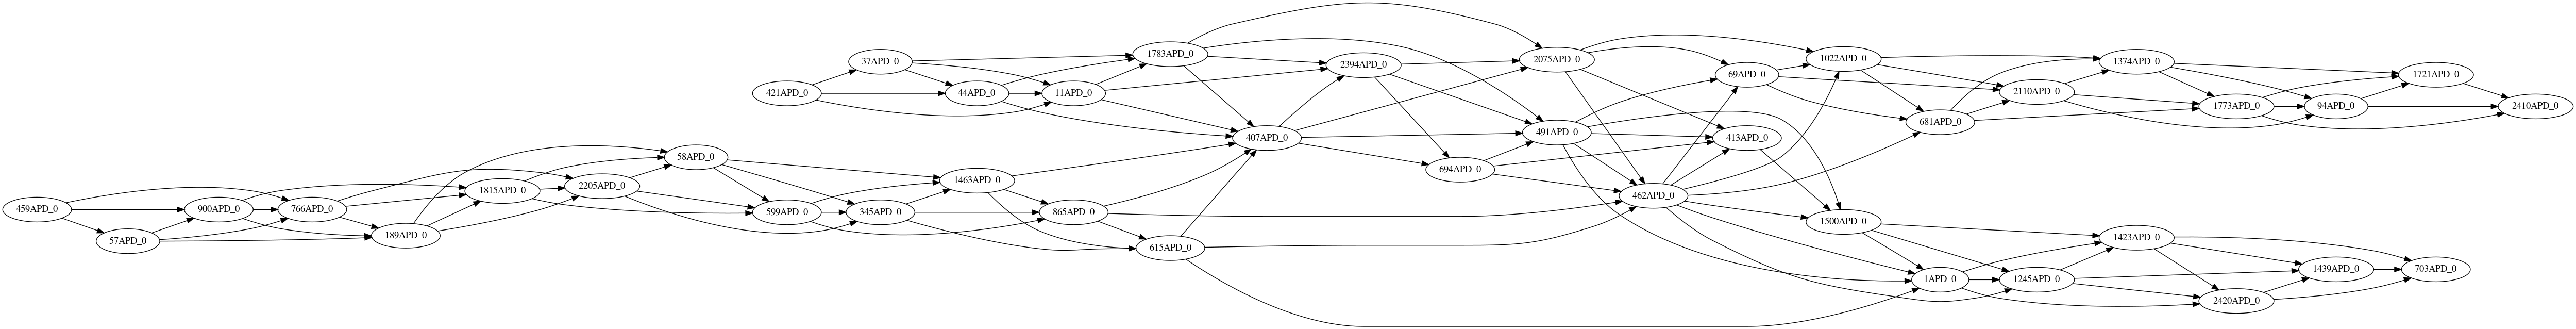

In [22]:
plot_graph(position_c,data2c,set(),None)
X= 

In [13]:
from gurobipy import *
from random import uniform
import itertools as it
import time
import cProfile as cP
import collections as coll
import math
import numpy as np
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 5
def contig_name(contig):
    return contig[:contig.rfind('_')]
def read_file(file_name, suffix = '_0'):
    """
    suffix -- wird dem Namen der Contigs angehangen, übergebe suffix = '' wenn der Suffix schon angehangen ist.
    """
    data = []
    with open(file_name) as file:
        for line in file:
            a, b, dist = line.split()
            dist = float(dist)
            data.append([a+suffix, b+suffix, dist])
    return data
def plot():
    x=[]
    l=[]
    for ii in range(20):
        i = 200*2**(ii/3)
        x.append(i)
        Z = {x: gruppiert(z[x], i) for x in z}
        l.append(sum(len(Z[x]) for x in Z) - len(Z))
    plt.plot(x,l,'.')
    plt.plot([1000,1000],[0,5000])
    plt.plot([2000,2000],[0,5000])
    plt.plot([3000,3000],[0,5000])
    plt.plot([4000,4000],[0,5000])
    plt.plot([5000,5000],[0,5000])
    plt.plot([6000,6000],[0,5000])
    plt.plot([7000,7000],[0,5000])
    plt.plot([8000,8000],[0,5000])
    plt.plot([9000,9000],[0,5000])
    plt.plot([10000,10000],[0,5000])
def gruppiert(werte, min_abstand):
    sorted_werte = sorted(werte) 
    # gruppiere sich stützende Daten
    previous = sorted_werte[0]
    current_group = []
    groups = []
    for current in sorted_werte:
        if current - previous > min_abstand:
            groups.append([current_group[len(current_group)//2], len(current_group)])
            current_group = []
        current_group.append(current)
        previous = current
    groups.append([current_group[len(current_group)//2], len(current_group)])
    return groups


data2 = read_file('my_apd199.lst', '')
z = coll.defaultdict(list)
for a,b,d in data2:
    if a>b:
        z[(b,a)].append(-d)
    elif a<b:
        z[(a,b)].append(d)
        
Z = {x: gruppiert(z[x], 500) for x in z}
#sorted([dist,a,b] for (a,b),(dist,gewicht) in Z.items())
print('len z[x] %6d'%sum(len(z[x]) for x in z))
print('len Z[x] %6d'%sum(len(Z[x]) for x in Z))
print('len C    %6d'%len(Z))
print('len Z-C  %6d'%(sum(len(Z[x]) for x in Z) - len(Z)))
print('len z-Z  %6d'%(sum(len(z[x]) for x in z) - sum(len(Z[x]) for x in Z)))


data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
len(data3)

len z[x] 121971
len Z[x]  55429
len C     49218
len Z-C    6211
len z-Z   66542


55429

In [77]:
data4 = [[a,b,d] for (d,a,b,g) in data3 if g > 2]
#data4
data4 = connected(data4)

Es gibt unzusammenhängende Regionen in den Daten
90.01% der Contigs sind in der größten Komponente.


In [83]:
g = nx.Graph()
for a,b,d in data4:
    g.add_edge(a,b)

In [84]:
X = [(set(nx.shortest_path(g,a)),a) for a in g if g.in_degree(a) == 0]

AttributeError: 'Graph' object has no attribute 'in_degree'

In [80]:
XX = deepcopy(X)
for x,y in X:
    xx = set()
    for x2,y2 in XX:
        if y2 != y:
            xx |= x2
    x -= xx

In [81]:
sorted((len(x),y) for x,y in X)

[(1, '1346APD_0'),
 (1, '1480APD_0'),
 (1, '1930APD_0'),
 (1, '2003APD_0'),
 (1, '2230APD_0'),
 (1, '2312APD_0'),
 (1, '2324APD_0'),
 (1, '509APD_0'),
 (2, '408APD_0'),
 (3, '2199APD_0'),
 (24, '1648APD_0'),
 (45, '2345APD_0')]

In [85]:
nx.periphery(g)

['899APD_0', '1483APD_0', '1821APD_0']

In [73]:
position = position_s
pos = sorted([(value, key) for key, value in position.items()])
intName = {k: i for i, (v, k) in enumerate(pos)}
intName.update({i: k for i, (v, k) in enumerate(pos)})


In [32]:
intName[701],intName2[700]

('40APD_0', '1874APD_0')

In [40]:
X

{'1160APD_0',
 '116APD_0',
 '1693APD_0',
 '1874APD_0',
 '2043APD_0',
 '326APD_0',
 '432APD_0',
 '576APD_0',
 '64APD_0',
 '744APD_0'}

In [ ]:
def ints_to_set(intName, ints):
    {intName[x] for x in ints}
X = {intName2[x] for x in [626,641,649,688,700,738,740,742,757,754]}

Anzahl der Änderungen: 0

güte 365.7879405543977
588171 2 2 5.5
610447 121 93 36.202428841830894
651120 1 1 0.0
658648 1 1 0.0
659609 30 3 6.433741224173866
681585 125 24 97.71644463752834

1. Repeat von 407APD
alte Positionen:
	 659607.0
neue Positionen:
	 681585.0
	 610447.0
ordne neuem repeat zu: 
Anzahl der Änderungen: 123





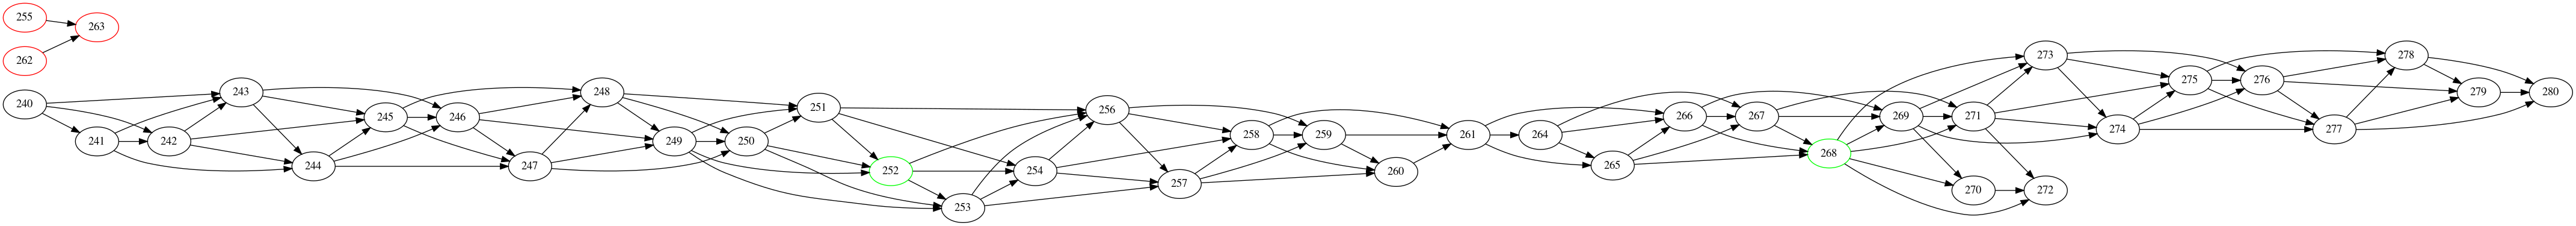

Anzahl der Änderungen: 0

güte 344.81644903437206
591674 1 1 0.0
613959 123 94 102.15495894052988
676505 1 1 0.0
685082 164 27 125.4625225963792

1. Repeat von 462APD
alte Positionen:
	 684981.0393698852
neue Positionen:
	 685082.0
	 613959.0
ordne neuem repeat zu: 
Anzahl der Änderungen: 126





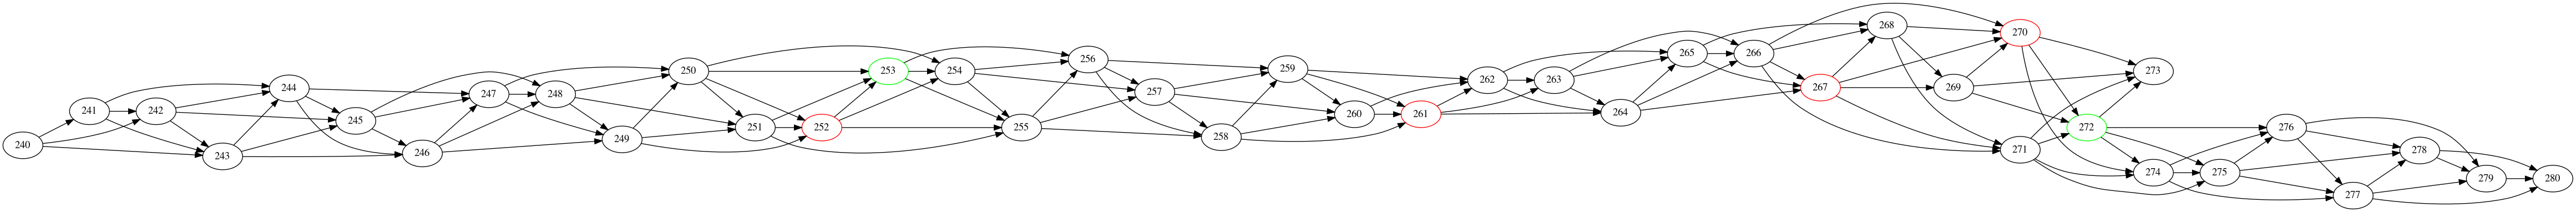

Anzahl der Änderungen: 2

güte 231.95775302061105
558868 1 1 0.0
581155 156 92 144.54966072279058
582125 2 2 19.0
621856 1 1 0.0
632864 3 1 47.48567035315905
634779 5 1 76.00631552706658
644143 143 114 234.64811452558533
653177 21 9 331.0356327263364
654590 3 1 47.48567035315906
672418 1 1 0.0
706687 1 1 0.0

1. Repeat von 58APD
alte Positionen:
	 643727.0393698852
neue Positionen:
	 581155.0393698852
	 644143.0393698852
ordne neuem repeat zu: 
Anzahl der Änderungen: 162





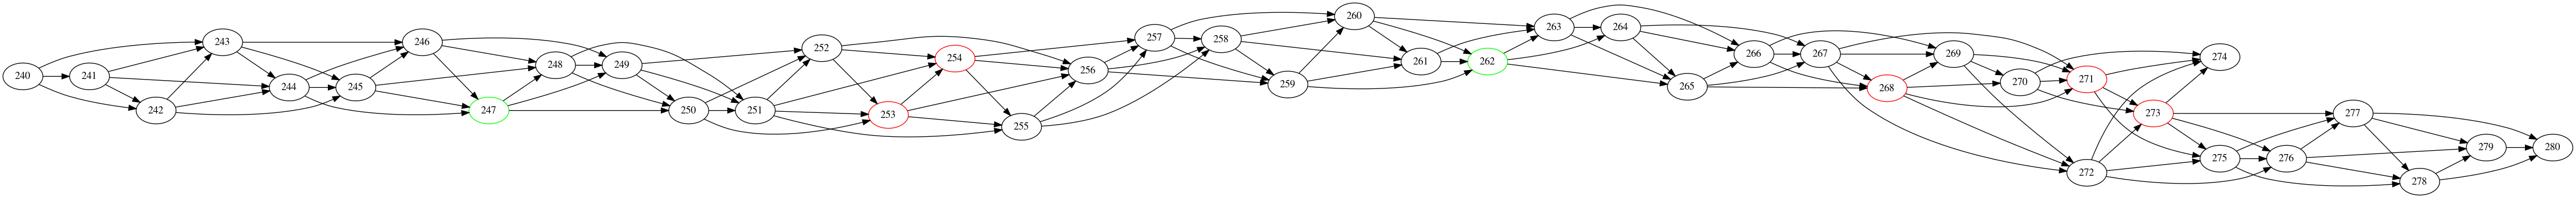

Anzahl der Änderungen: 0

by


In [130]:
X = {'1011APD_0',
 '1064APD_0',
 '113APD_0',
 '1160APD_0',
 '116APD_0',
 '1208APD_0',
 '1224APD_0',
 '1379APD_0',
 '1391APD_0',
 '143APD_0',
 '1505APD_0',
 '1510APD_0',
 '1693APD_0',
 '1769APD_0',
 '178APD_0',
 '1874APD_0',
 '18APD_0',
 '1923APD_0',
 '1927APD_0',
 '2043APD_0',
 '211APD_0',
 '221APD_0',
 '2278APD_0',
 '2301APD_0',
 '2324APD_0',
 '2459APD_0',
 '271APD_0',
 '291APD_0',
 '326APD_0',
 '332APD_0',
 '342APD_0',
 '40APD_0',
 '432APD_0',
 '476APD_0',
 '501APD_0',
 '53APD_0',
 '576APD_0',
 '64APD_0',
 '650APD_0',
 '658APD_0',
 '744APD_0',
 '853APD_0'}
"""
{'1011APD_0',
 '1064APD_0',
 '113APD_0',
 '1160APD_0',
 '116APD_0',
 '1208APD_0',
 '1224APD_0',
 '1379APD_0',
 '1391APD_0',
 '143APD_0',
 '1505APD_0',
 '1510APD_0',
 '1693APD_0',
 '1769APD_0',
 '178APD_0',
 '1874APD_0',
 '18APD_0',
 '1923APD_0',
 '1927APD_0',
 '2043APD_0',
 '211APD_0',
 '221APD_0',
 '2278APD_0',
 '2301APD_0',
 '2324APD_0',
 '2459APD_0',
 '271APD_0',
 '291APD_0',
 '326APD_0',
 '332APD_0',
 '342APD_0',
 '40APD_0',
 '432APD_0',
 '476APD_0',
 '501APD_0',
 '576APD_0',
 '64APD_0',
 '744APD_0',
 '853APD_0'} | {intName[x] for x in [836,838,843]}"""
#datas, dataXs, position_s, Xs, contig_repeats = init_X('my_apd199.lst',{'407APD_0', '462APD_0', '491APD_0','58APD_0'})
data_s = [d for d in datas if d[0] not in Xs and d[1] not in Xs]
data =  deepcopy(datas)
XX = deepcopy(Xs)
dataX = [d for d in data if d[0] in XX or d[1] in XX]
i = verbessere_loop(data, dataX, deepcopy(position_s), XX, deepcopy(contig_repeats))
#Xs,XX

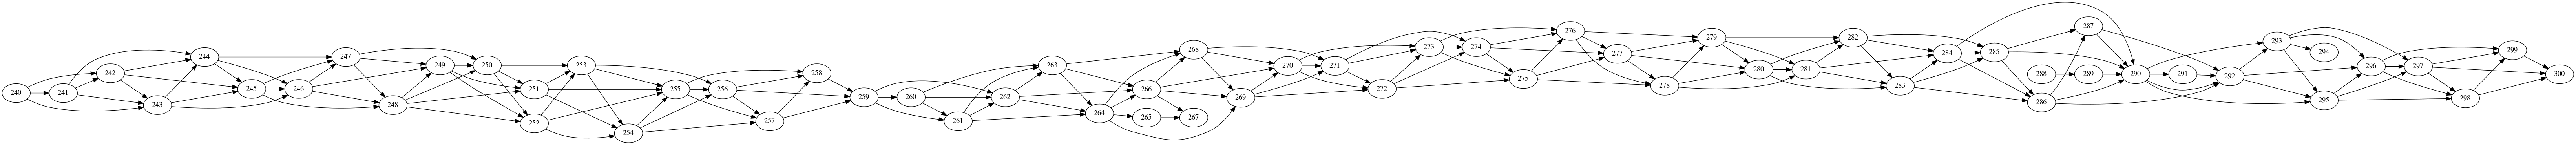

In [129]:
intName = get_intName(position_s)
plot_graph(position_s, data_s,intName,set(),None,240,300,kantenanzahl=3,fehler=5000)

In [122]:
intName[247]

'58APD_0'

In [15]:
X

{'1011APD_0',
 '1064APD_0',
 '113APD_0',
 '1160APD_0',
 '116APD_0',
 '1208APD_0',
 '1224APD_0',
 '1379APD_0',
 '1391APD_0',
 '143APD_0',
 '1505APD_0',
 '1510APD_0',
 '1693APD_0',
 '1769APD_0',
 '178APD_0',
 '1874APD_0',
 '18APD_0',
 '1923APD_0',
 '1927APD_0',
 '2043APD_0',
 '211APD_0',
 '221APD_0',
 '2278APD_0',
 '2301APD_0',
 '2324APD_0',
 '2459APD_0',
 '271APD_0',
 '291APD_0',
 '326APD_0',
 '332APD_0',
 '342APD_0',
 '40APD_0',
 '432APD_0',
 '476APD_0',
 '501APD_0',
 '53APD_0',
 '576APD_0',
 '64APD_0',
 '650APD_0',
 '658APD_0',
 '744APD_0',
 '853APD_0'}

In [90]:

def graph(position, data, intName, X, repeat, von = 240, bis = 280, kantenanzahl = 3, fehler = 1000):

    s = coll.defaultdict(set)
    p = coll.defaultdict(set)

    graph = nx.Graph() 
    for c in X:
        if contig_name(c) == repeat:
            graph.add_node(intName[c],color = 'green')
        else:
            graph.add_node(intName[c],color = 'red')
    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a].add(b)
            p[b].add(a)

    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    
    for el in pp:
        for pr in pp[el]:
            graph.add_edge(intName[pr],intName[el])
           # graph.add_edge(pr,el)
    for el in ss:
        for su in ss[el]:
          #  graph.add_edge(el,su)
            graph.add_edge(intName[el],intName[su])

    return graph

In [94]:
g = graph(position_s, data_s,intName,set(),None,-1,8000,kantenanzahl=2,fehler=5000)

In [95]:
A1 = nx.node_connected_component(g, 0)
A2 = nx.node_connected_component(g, 1)
A3 = nx.node_connected_component(g, 2)

In [96]:
A4 = {x for x in range(2042) if x not in g}
A4

{3, 2039, 2040, 2041}

In [102]:

data = [d for d in datas if d[0] not in X and d[1] not in X]
for a, b, dist in data:
    ia, ib = intName[a], intName[b]
    if {ia,ib} < A1 or  {ia,ib} < A2 or  {ia,ib} < A3:
        continue
        
    real_dist = position[b] - position[a]
        
    #print(a,b,dist)
    if ia in A1:
        Ma = 'A1'
    if ia in A2:
        Ma = 'A2'
    if ia in A3:
        Ma = 'A3'
    if ia in A4:
        Ma = 'A4'
    if ib in A1:
        Mb = 'A1'
    if ib in A2:
        Mb = 'A2'
    if ib in A3:
        Mb = 'A3'
    if ib in A4:
        Mb = 'A4'
        
    print(Ma, Mb, dist - real_dist)
  #  print(abs(real_dist - dist))
   # print(position[a])
    #print(position[b])
        


A1 A2 479938.0
A1 A2 479892.0
A1 A2 479938.0
A1 A2 479892.0
A1 A3 -1268827.4577293987
A3 A2 -283089.45870243217
A2 A3 595677.5172876426
A2 A3 595707.5172876426
A2 A3 595769.5172876426
A3 A1 1321362.000897786
A3 A1 1321349.000897786
A3 A1 1321312.000897786


In [103]:
connected(data_s)

Die Daten sind zusammenhängend


[['1001APD_0', '1001APD_0', 28483.0],
 ['1001APD_0', '100APD_0', 53815.0],
 ['1001APD_0', '1046APD_0', 151293.0],
 ['1001APD_0', '10APD_0', 13985.0],
 ['1001APD_0', '10APD_0', 14118.0],
 ['1001APD_0', '10APD_0', 14260.0],
 ['1001APD_0', '10APD_0', 14387.0],
 ['1001APD_0', '10APD_0', 14443.0],
 ['1001APD_0', '10APD_0', 14522.0],
 ['1001APD_0', '10APD_0', 14528.0],
 ['1001APD_0', '10APD_0', 14547.0],
 ['1001APD_0', '10APD_0', 14997.0],
 ['1001APD_0', '1130APD_0', 126367.0],
 ['1001APD_0', '1133APD_0', 135464.0],
 ['1001APD_0', '1331APD_0', 38824.0],
 ['1001APD_0', '1418APD_0', 19558.0],
 ['1001APD_0', '1418APD_0', 19724.0],
 ['1001APD_0', '1418APD_0', 19769.0],
 ['1001APD_0', '1488APD_0', 25744.0],
 ['1001APD_0', '1488APD_0', 26084.0],
 ['1001APD_0', '1496APD_0', 10721.0],
 ['1001APD_0', '1496APD_0', 10742.0],
 ['1001APD_0', '1496APD_0', 10825.0],
 ['1001APD_0', '1496APD_0', 10867.0],
 ['1001APD_0', '1501APD_0', 30760.0],
 ['1001APD_0', '1501APD_0', 31033.0],
 ['1001APD_0', '1550APD_0', 

In [66]:
1133 in A3, 1134 in A2

(True, True)

In [47]:
position_s[intName[2040]]

2859922.751857877

In [132]:

datas, dataXs, position_s, Xs, contig_repeats = init_X('my_apd199.lst',set())

Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
Die Daten sind zusammenhängend
Optimize a model with 244358 rows, 124260 columns and 732074 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-06, 8e-06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 502 rows and 252 columns
Presolve time: 1.87s
Presolved: 243856 rows, 124008 columns, 731568 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1282
 AA' NZ     : 4.295e+06
 Factor NZ  : 6.595e+06 (roughly 200 MBytes of memory)
 Factor Ops : 9.422e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.46180813e+05  3.72097087e+01  0.00e+00 0.00e+00  7.45e+04    18s
   1   7.46139995e+05  

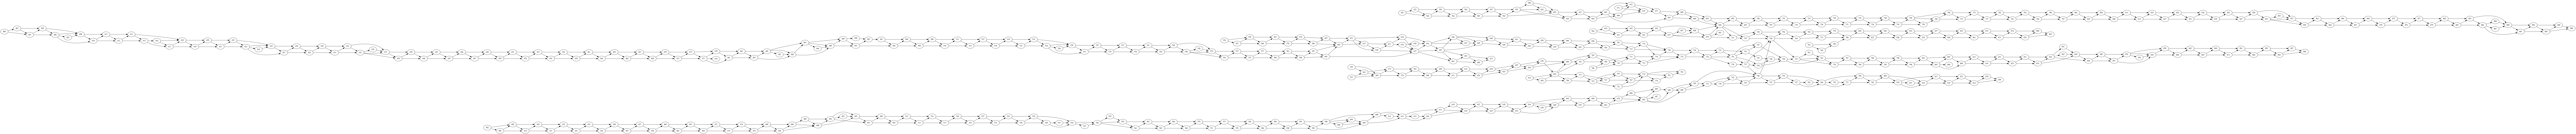

In [139]:
plot_graph(position_s, data_s,intName,set(),None,400,900,kantenanzahl=2,fehler=500)

In [165]:

s = coll.defaultdict(set)
p = coll.defaultdict(set)

for a, b, dist in data:
    if b == '2345APD_0':
        print(a,b,dist)
    s[a].add(b)
    p[b].add(a)

431APD_0 2345APD_0 2869.0


In [141]:
intName[0]

'2345APD_0'

In [152]:
intName[0],intName[2076]

('2345APD_0', '2080APD_0')

In [157]:
p['2345APD_0']

{'431APD_0'}

In [158]:
intName[2076]

'2080APD_0'

In [161]:
s['2080APD_0']

set()

In [21]:
def get_intName(position):

    pos = sorted([(value, key) for key, value in position.items()])
    
    intName = {k: i for i, (v, k) in enumerate(pos)}
    intName.update({i: k for i, (v, k) in enumerate(pos)})
    
    return intName

def pfadkontraktion2(graph):
    nodes = set(graph.nodes)
    rename = {node : str(node) for node in nodes}
    while nodes:
        node = nodes.pop()
        if not graph.succ[node]:
            continue
        succ = min(graph.succ[node])
        if (        set(graph.pred[succ]) - {node} <= set(graph.pred[node]) 
                and set(graph.succ[node]) - {succ} <= set(graph.succ[succ])):
            graph = nx.contracted_edge(graph,(node, succ), False)
            rename[node] = rename[node] + '\n' + rename[succ]
            if succ in nodes:
                nodes.remove(succ)
            nodes.add(node)
            nodes |= set(graph.pred[node])
                
    return nx.relabel_nodes(graph, rename)

def plot_graph_rev(position, data, von = -1, bis = 3280, kantenanzahl = 2, fehler = 1000):
    
    intName = get_intName(position)
    
    s = coll.defaultdict(set)
    p = coll.defaultdict(set)

    graph = nx.DiGraph() 
    
    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a].add(b)
            p[b].add(a)
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    endpunkte = (set(pp) - set(ss)) | (set(ss) - set(pp))
    """
    
    for a, b, dist in data:
        if a in endpunkte or b in endpunkte:
            if position[a] > position[b]:
                a, b = b, a
            graph.add_edge(intName[a],intName[b],color = 'red')
    """
    constr_pos = get_constr_pos(data,position)
    for a in endpunkte:
        groups = gruppierung_Q(constr_pos[a], 1000)
        for group in groups:
            b = group.contig
            if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
                continue
            if position[a] > position[b]:
                color = 'red' if group.orientierung else 'green'
                graph.add_edge(intName[b],intName[a],color = color)
            else:
                color = 'blue' if group.orientierung else 'indigo'
                graph.add_edge(intName[a],intName[b],color = color)
            
    for el in pp:
        for pr in pp[el]:
            graph.add_edge(intName[pr],intName[el])
           # graph.add_edge(pr,el)
    for el in ss:
        for su in ss[el]:
          #  graph.add_edge(el,su)
            graph.add_edge(intName[el],intName[su])
    
    graph = pfadkontraktion2(graph)
    pydot = nx.nx_pydot.to_pydot(graph)
 #   pydot.set_rankdir('LR')
    
    pydot.write_png('t.png')
 #   display(Image(filename='t.png'))
    
def get_constr_pos(data, position):
    constr_pos = coll.defaultdict(list)
    for a, b, dist in data:
        
        constr_pos[b].append((position[a] + dist, a, -dist, True))
        constr_pos[a].append((position[b] - dist, b, dist, False))
    return dict(constr_pos)


def extrahiere_daten_Q(gruppe):
    gruppe, counter, dist_contig, orientierung  = gruppe
    
    if len(orientierung) != 1:
        return
    Repeat = coll.namedtuple('Repeat', ['contig', 'güte', 'orientierung'])

    anzahl = len(gruppe)
    güte = (anzahl-1)**2 * (max(counter.values()) - 1) / (200+np.std(gruppe))
    
    if güte == 0:
        return
    
    dist_contig.sort()
    if {True} == orientierung:
        contig = dist_contig[-1][1]
    elif {False} == orientierung:
        contig = dist_contig[0][1]
    else:
        1/0
        
    return Repeat(
        contig = contig, 
        güte = güte,
        orientierung = list(orientierung)[0],
    )
   
def gruppierung_Q(positionen, min_abstand):
    
    sorted_pos = sorted(positionen) 
    
    previous = sorted_pos[0][0]
    current_group = [[],coll.Counter(),[],set()]
    groups = []
    
    for current, contig, dist, direction in sorted_pos:
        if current - previous > min_abstand:
            g = extrahiere_daten_Q(current_group)
            if g:
                groups.append(g)
            current_group = [[],coll.Counter(),[],set()]
            
        current_group[0].append(current)
        current_group[1][contig] += 1
        current_group[2].append((dist, contig))
        current_group[3].add(direction)
        
        previous = current
        
    g = extrahiere_daten_Q(current_group)
    if g:
        groups.append(g)
    
  #  groups = [g for g in groups if g.güte > 0]
    
    return groups


In [22]:
def init_Y(datei):
    data = read_file(datei)
    r = coll.Counter()
    for a,b,d in data:
        r[a] += 1
        r[b] += 1
    
    data = [[a,b,d] for a,b,d in data if r[a] > 1 and r[b] > 1]
    data = connected(data)

    position = {a for a,_,_ in data} | {b for _,b,_ in data}
    
    position = solve_LP(position, data)
    
    return data, position

In [23]:

#data, position = init_Y('my_apd199.lst')

plot_graph_rev(position, data,von = -1, bis = 9000, kantenanzahl=1,fehler = 5000)

In [ ]:
def pfadkontraktion2(graph):
    nodes = set(graph.nodes)
    rename = {node : str(node) for node in nodes}
    while nodes:
        node = nodes.pop()
        if not graph.succ[node]:
            continue
        succ = min(graph.succ[node])
        if (        set(graph.pred[succ]) - {node} <= set(graph.pred[node]) 
                and set(graph.succ[node]) - {succ} <= set(graph.succ[succ])):
            graph = nx.contracted_edge(graph,(node, succ), False)
            rename[node] = rename[node] + '\n' + rename[succ]
            if succ in nodes:
                nodes.remove(succ)
            nodes.add(node)
            nodes |= set(graph.pred[node])
                
    return nx.relabel_nodes(graph, rename)